# A Deep State Space Model for Multivariate Time Series and Control Signals

## Notations

- $x_t$: timeseries (e.g., sensor measurements)
- $u_t$: control signals
- $z_t$: latent states

## References

- Kalman filter:  
[https://en.wikipedia.org/wiki/Kalman_filter](https://en.wikipedia.org/wiki/Kalman_filter)

- DSSM paper:  
[https://dl.acm.org/doi/10.1145/3394486.3403206](https://dl.acm.org/doi/10.1145/3394486.3403206)

- An official TensorFlow impolementation of DSSM:  
[https://github.com/Google-Health/records-research/tree/master/state-space-model](https://github.com/Google-Health/records-research/tree/master/state-space-model)

In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal


In [3]:
class GatedTransition(nn.Module):
    def __init__(self, z_dim, hid_dim):
        super(GatedTransition, self).__init__()

        self.gate = nn.Sequential(nn.Linear(z_dim, hid_dim),
                                  nn.ReLU(),
                                  nn.Linear(hid_dim, z_dim),
                                  nn.Sigmoid())

        self.proposed_mean = nn.Sequential(nn.Linear(z_dim, hid_dim),
                                           nn.ReLU(),
                                           nn.Linear(hid_dim, z_dim))

        self.z_to_mu = nn.Linear(z_dim, z_dim)
        # modify the default initialization of z_to_mu
        # so that it starts out as the identity function
        self.z_to_mu.weight.data = torch.eye(z_dim)
        self.z_to_mu.bias.data = torch.zeros(z_dim)

        self.z_to_logvar = nn.Linear(z_dim, z_dim)
        self.relu = nn.ReLU()

    def forward(self, z_t_1):
        #
        gate = self.gate(z_t_1)
        proposed_mean = self.proposed_mean(z_t_1)
        mu = (1 - gate) * self.z_to_mu(z_t_1) + gate * proposed_mean
        logvar = self.z_to_logvar(self.relu(proposed_mean))
        # sampling
        eps = torch.randn(z_t_1.size())
        z_t = mu + eps * torch.exp(.5 * logvar)
        return z_t, mu, logvar


In [4]:
class ControlTransition(nn.Module):
    def __init__(self, signal_dim, z_dim, hid_dim=32):
        super(ControlTransition, self).__init__()
        self.input_dim = signal_dim
        self.u_to_hidden = nn.Linear(signal_dim, hid_dim)
        self.hidden_to_z = nn.Linear(hid_dim, z_dim)

    def forward(self, u_t):
        h_t = self.u_to_hidden(u_t)
        h_t = self.hidden_to_z(h_t)
        return h_t

In [5]:
class Combiner(nn.Module):
    # PostNet
    def __init__(self, z_dim, hid_dim):
        super(Combiner, self).__init__()
        self.z_dim = z_dim
        self.z_to_hidden = nn.Linear(z_dim, hid_dim)
        self.hidden_to_mu = nn.Linear(hid_dim, z_dim)
        self.hidden_to_logvar = nn.Linear(hid_dim, z_dim)
        self.tanh = nn.Tanh()

    def forward(self, z_t_1, h_rnn):
        # combine the rnn hidden state with a transformed version of z_t_1
        # Line 577 in the original code
        h_combined = 0.5 * (self.tanh(self.z_to_hidden(z_t_1)) + h_rnn)
        # use the combined hidden state
        # to compute the mean used to sample z_t
        mu = self.hidden_to_mu(h_combined)
        # use the combined hidden state
        # to compute the scale used to sample z_t
        logvar = self.hidden_to_logvar(h_combined)
        eps = torch.randn(z_t_1.size())
        z_t = mu + eps * torch.exp(.5 * logvar)
        return z_t, mu, logvar


In [43]:
class Emitter(nn.Module):
    def __init__(self, z_dim, hid_dim, input_dim) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.z_to_hidden = nn.Linear(z_dim, hid_dim)
        self.hidden_to_hidden = nn.Linear(hid_dim, hid_dim)
        self.hidden_to_input_mu = nn.Linear(hid_dim, input_dim)
        self.logvar = nn.Parameter(torch.ones(input_dim))
        self.relu = nn.ReLU()

    def forward(self, z_t):
        h1 = self.relu(self.z_to_hidden(z_t))
        h2 = self.relu(self.hidden_to_hidden(h1))
        mu = self.hidden_to_input_mu(h2)
        # return mu  # x_t
        eps = torch.randn(z_t.size(0), self.input_dim)
        x_t = mu + eps * torch.exp(.5 * self.logvar)
        return x_t, mu, self.logvar


In [56]:
class IntervEmitter(nn.Module):
    def __init__(self, input_dim, z_dim, hid_dim=32) -> None:
        super().__init__()
        self.emitter = nn.Sequential(
            nn.Linear(z_dim, hid_dim),
            nn.Linear(hid_dim, hid_dim),
            nn.Linear(hid_dim, input_dim))

    def forward(self, z_t_1):
        return self.emitter(z_t_1)

In [214]:
class DKF(nn.Module):
    # Structured Inference Networks
    # Current version ignores backward RNN outputs
    def __init__(self, x_dim, u_dim=0, z_dim=50,
                 trans_dim=30, emission_dim=30, interv_dim=30,
                 rnn_dim=100, num_rnn_layers=1) -> None:

        super().__init__()

        self.input_dim = x_dim
        self.signal_dim = u_dim
        self.z_dim = z_dim
        self.trans_dim = trans_dim
        self.emission_dim = emission_dim
        self.rnn_dim = rnn_dim
        self.num_rnn_layers = num_rnn_layers

        self.trans = GatedTransition(z_dim, trans_dim)
        self.emitter = Emitter(z_dim, emission_dim, x_dim)
        self.combiner = Combiner(z_dim, rnn_dim)

        if u_dim > 0:
            self.control_trans = ControlTransition(u_dim, z_dim, interv_dim)
            self.control_emitter = IntervEmitter(u_dim, z_dim, interv_dim)
            self.control_noise = nn.Parameter(torch.eye(u_dim))

        self.z_0 = nn.Parameter(torch.zeros(z_dim))
        self.z_q_0 = nn.Parameter(torch.zeros(z_dim))
        self.h_0 = nn.Parameter(torch.zeros(1, 1, rnn_dim))

        self.rnn = nn.RNN(input_size=x_dim+u_dim,
                          hidden_size=rnn_dim,
                          nonlinearity="relu",
                          batch_first=True,
                          bidirectional=False,
                          num_layers=num_rnn_layers)

    def kl_div(self, mu1, logvar1, mu2=None, logvar2=None):

        if mu2 is None:
            mu2 = torch.zeros(1, device=mu1.device)

        if logvar2 is None:
            logvar2 = torch.zeros(1, device=mu1.device)

        return torch.sum(0.5 * (
            logvar2 - logvar1 + (torch.exp(logvar1) + (mu1 - mu2).pow(2))
            / torch.exp(logvar2) - torch.ones(1, device=mu1.device)
        ), 1)

    def infer(self, x, u=None):

        batch_size, T_max, _ = x.size()
        h_0 = self.h_0.expand(1, batch_size, self.rnn_dim).contiguous()

        if u is not None:
            # concatenate measurements and control signals
            # over their feature dimensions
            input_seq = torch.cat((x, u), -1)
        else:
            input_seq = x

        rnn_out, _ = self.rnn(input_seq, h_0)

        z_prev = self.z_q_0.expand(batch_size, self.z_q_0.size(0))
        kl_states = torch.zeros((batch_size, T_max))
        rec_losses = torch.zeros((batch_size, T_max))
        rec_u_losses = torch.zeros((batch_size, T_max))

        for t in range(T_max):
            # p(z_t|z_{t-1})
            z_prior, z_prior_mu, z_prior_logvar = self.trans(z_prev)
            if u is not None:
                # z_prior_mu is further biased by u_t
                z_prior_mu += self.control_trans(u[:, t])

            # q(z_t|z_{t-1},x_{t:T})
            z_t, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, t])
            # p(x_t|z_t)
            x_t, x_mu, x_logvar = self.emitter(z_t)

            if u is not None:
                u_mu = self.control_emitter(z_prev)
                u_dist = MultivariateNormal(
                    loc=torch.zeros(self.signal_dim),
                    scale_tril=torch.linalg.cholesky(self.control_noise))
                rec_u_losses[:, t] = -1 * u_dist.log_prob(u[:, t] - u_mu)

            # compute loss

            kl_states[:, t] = self.kl_div(
                z_mu, z_logvar, z_prior_mu, z_prior_logvar)

            rec_losses[:, t] = nn.MSELoss(reduction='none')(
                x_t.contiguous().view(-1),
                # x_mu.contiguous().view(-1),
                x[:, t].contiguous().view(-1)
            ).view(batch_size, -1).mean(dim=1)

            z_prev = z_t

        return rec_losses.mean() + rec_u_losses.mean(), kl_states.mean()

    def filter(self, x, u=None, num_sample=100):

        # Outputs
        x_hat = torch.zeros(x.size())  # predictions
        x_025 = torch.zeros(x.size())
        x_975 = torch.zeros(x.size())

        batch_size, T_max, x_dim = x.size()
        assert batch_size == 1
        z_prev = self.z_0.expand(num_sample, self.z_0.size(0))

        h_0 = self.h_0.expand(1, 1, self.rnn_dim).contiguous()
        rnn_out, _ = self.rnn(x, h_0)
        rnn_out = rnn_out.expand(num_sample,
                                 rnn_out.size(1), rnn_out.size(2))

        for t in range(T_max):
            # z_t: (num_sample, z_dim)
            z_t, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, t])
            x_t, x_mu, x_logvar = self.emitter(z_t)
            # x_hat[:, t] = x_mu

            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()
            # # sampling z_t and computing quantiles
            # x_samples = MultivariateNormal(
            #     loc=x_mu, covariance_matrix=x_covar).sample_n(num_sample)

            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)

            # x_hat[:, t] = x_t.mean(0)
            # x_025[:, t] = x_t.quantile(0.025, 0)
            # x_975[:, t] = x_t.quantile(0.975, 0)

            z_prev = z_t
            # z_prev = z_mu

        return x_hat, x_025, x_975

    def predict(self, x, u=None, pred_steps=1, num_sample=100):
        """ x should contain the prediction period
        """
        # Outputs
        x_hat = torch.zeros(x.size())  # predictions
        x_025 = torch.zeros(x.size())
        x_975 = torch.zeros(x.size())

        if u is not None:
            u_hat = torch.zeros(u.size())  # predictions
            u_025 = torch.zeros(u.size())
            u_975 = torch.zeros(u.size())

        batch_size, T_max, x_dim = x.size()
        assert batch_size == 1
        z_prev = self.z_0.expand(num_sample, self.z_0.size(0))

        h_0 = self.h_0.expand(1, 1, self.rnn_dim).contiguous()
        if u is not None:
            # concatenate measurements and control signals
            # over their feature dimensions
            input_seq = torch.cat((x, u), -1)
        else:
            input_seq = x

        rnn_out, _ = self.rnn(input_seq[:, :T_max-pred_steps], h_0)
        rnn_out = rnn_out.expand(num_sample,
                                 rnn_out.size(1), rnn_out.size(2))

        for t in range(T_max - pred_steps):

            # z_t: (num_sample, z_dim)
            z_t, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, t])

            if u is not None:
                z_t += self.control_trans(u[:, t])
                u_mu = self.control_emitter(z_prev)
                # print(u_mu.size())  # (num_sample, z_dim)
                u_dist = MultivariateNormal(
                    loc=u_mu, scale_tril=torch.linalg.cholesky(self.control_noise))

                u_samples = u_dist.sample()
                # print(u_samples.size())
                u_hat[:, t] = u_samples.mean(0)
                u_025[:, t] = u_samples.quantile(0.025, 0)
                u_975[:, t] = u_samples.quantile(0.975, 0)

            x_t, x_mu, x_logvar = self.emitter(z_t)

            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()

            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)

            z_prev = z_mu

        for t in range(T_max - pred_steps, T_max):

            rnn_out, _ = self.rnn(input_seq[:, :t], h_0)
            rnn_out = rnn_out.expand(
                num_sample, rnn_out.size(1), rnn_out.size(2))

            z_t_1, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, -1])
            z_t, z_mu, z_logvar = self.trans(z_t_1)

            if u is not None:
                z_t += self.control_trans(u[:, t])
                u_mu = self.control_emitter(z_prev)
                # print(u_mu.size())  # (num_sample, z_dim)
                u_dist = MultivariateNormal(
                    loc=u_mu, scale_tril=torch.linalg.cholesky(self.control_noise))

                u_samples = u_dist.sample()
                # print(u_samples.size())
                u_hat[:, t] = u_samples.mean(0)
                u_025[:, t] = u_samples.quantile(0.025, 0)
                u_975[:, t] = u_samples.quantile(0.975, 0)

            x_t, x_mu, x_logvar = self.emitter(z_t)

            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()

            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)

            z_prev = z_mu

        if u is None:
            return x_hat, x_025, x_975
        else:
            return x_hat, x_025, x_975, u_hat, u_025, u_975

    def train_step(self, x, u, annealing_factor=0.1):
        self.train()
        # self.rnn.train()
        rec_loss, kl_loss = self.infer(x, u)
        total_loss = rec_loss + annealing_factor * kl_loss
        self.optimizer.zero_grad()
        total_loss.backward()
        # nn.utils.clip_grad_norm_(self.parameters(), 5.)
        self.optimizer.step()
        return rec_loss.item(), kl_loss.item(), total_loss.item()

    def validation_step(self, x, annealing_factor=0.1):
        self.eval()
        rec_loss, kl_loss = self.infer(x)
        total_loss = rec_loss + annealing_factor * kl_loss
        return rec_loss.item(), kl_loss.item(), total_loss.item()

    def fit(self, x, u, x_val=None, u_val=None,
            num_epochs=100, annealing_factor=0.1,
            verbose_step=1, eval_step=1, check_point_path=None,
            patience=20, learning_rate=0.01):

        self.optimizer = torch.optim.Adam(
            self.parameters(), lr=learning_rate)

        losses = []
        kl_losses = []
        rec_losses = []
        val_losses = []
        val_kl_losses = []
        val_rec_losses = []

        for epoch in range(num_epochs):
            try:
                res = self.train_step(x, u, annealing_factor=annealing_factor)
                losses.append(res[2])
                kl_losses.append(res[1])
                rec_losses.append(res[0])

                if epoch % verbose_step == verbose_step - 1:
                    message = f'Epoch= {epoch+1}/{num_epochs}, '
                    message += f'loss= {res[2]:.3f}, '
                    message += f'mse= {res[0]:.3f}, '
                    message += f'kld= {res[1]:.3f}'
                    print(message)

                if x_val is not None:
                    val_res = self.validation_step(x_val, annealing_factor)
                    val_losses.append(val_res[2])
                    val_kl_losses.append(val_res[1])
                    val_rec_losses.append(val_res[0])

                if epoch % eval_step == eval_step - 1 and x_val is not None:
                    message = f'\tval_loss= {val_res[2]:.3f}, '
                    message += f'val_mse= {val_res[0]:.3f}, '
                    message += f'val_kld= {val_res[1]:.3f}'
                    print(message)

            except KeyboardInterrupt:
                break

        history = {'loss': losses,
                   'kl_loss': kl_losses,
                   'rec_loss': rec_losses}

        if x_val is not None:
            history.update({'val_loss': val_losses,
                            'val_kl_loss': val_kl_losses,
                            'val_rec_loss': val_rec_losses})

        return history

    def save_model(self, filename):
        """ dkf.pth """
        torch.save(self.to('cpu').state_dict(), filename)

    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))

    def get_config(self):
        return {
            'input_dim': self.input_dim,
            'z_dim': self.z_dim,
            'trans_dim': self.trans_dim,
            'emission_dim': self.emission_dim,
            'rnn_dim': self.rnn_dim,
            'num_rnn_layers': self.num_rnn_layers
        }

    @staticmethod
    def timeseries_to_tensor(x, batch_first=False):
        # output tensor shape: (batch_size, # samples, # features)
        if x.ndim == 1:
            # batch_size = 1 and # sequences = 1
            return torch.FloatTensor(x).reshape(1, len(x), 1)
        elif x.ndim == 2 and batch_first == True:
            # features = 1
            return torch.FloatTensor(x).reshape(*x.shape, 1)
        elif x.ndim == 2 and batch_first == False:
            # batch_size = 1
            return torch.FloatTensor(x).reshape(1, *x.shape)
        elif x.ndim == 3:
            return torch.FloatTensor(x)
        else:
            raise ValueError


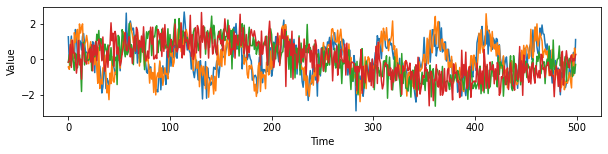

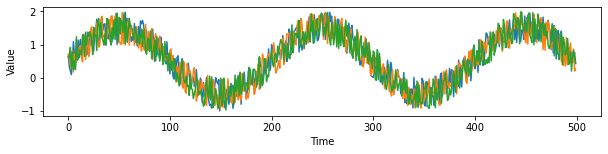

In [228]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import scale
# import warnings
# warnings.filterwarnings('ignore')

T = 500  # sequence length
observations = 2*np.sin(np.linspace(0, 20*np.pi, T))
interventions = 2*np.sin(np.linspace(0, 2*np.pi, T))

data = np.vstack([observations, observations*1.2,
                 interventions, interventions*0.85]).T
data += np.random.randn(*data.shape)
# data[:, 2:] = preprocessing.minmax_scale(data[:, 2:])
data = scale(data)

signal = np.random.rand(T, 3) + np.tile(np.sin(np.linspace(0, 5*np.pi, T)), (3, 1)).T

plt.figure(figsize=(10, 2))
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(signal)
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


In [229]:
dkf = DKF(data.shape[1], signal.shape[1])

In [230]:
x_ten = dkf.timeseries_to_tensor(data)
u_ten = dkf.timeseries_to_tensor(signal)
x_ten.size()
u_ten.size()

torch.Size([1, 500, 3])

In [231]:
history = dkf.fit(x_ten, u_ten, num_epochs=200)
history = pd.DataFrame(history)
# history

Epoch= 1/200, loss= 9.168, mse= 8.022, kld= 11.464
Epoch= 2/200, loss= 8.367, mse= 7.688, kld= 6.793
Epoch= 3/200, loss= 7.579, mse= 7.064, kld= 5.150
Epoch= 4/200, loss= 45.169, mse= 37.607, kld= 75.619
Epoch= 5/200, loss= 7.322, mse= 6.909, kld= 4.132
Epoch= 6/200, loss= 7.813, mse= 7.353, kld= 4.598
Epoch= 7/200, loss= 7.873, mse= 7.376, kld= 4.978
Epoch= 8/200, loss= 8.056, mse= 7.521, kld= 5.342
Epoch= 9/200, loss= 7.911, mse= 7.390, kld= 5.211
Epoch= 10/200, loss= 7.858, mse= 7.378, kld= 4.801
Epoch= 11/200, loss= 7.804, mse= 7.368, kld= 4.353
Epoch= 12/200, loss= 7.863, mse= 7.485, kld= 3.783
Epoch= 13/200, loss= 7.748, mse= 7.409, kld= 3.385
Epoch= 14/200, loss= 7.768, mse= 7.479, kld= 2.889
Epoch= 15/200, loss= 7.731, mse= 7.462, kld= 2.689
Epoch= 16/200, loss= 7.515, mse= 7.278, kld= 2.377
Epoch= 17/200, loss= 7.519, mse= 7.303, kld= 2.162
Epoch= 18/200, loss= 7.248, mse= 7.059, kld= 1.884
Epoch= 19/200, loss= 7.259, mse= 7.085, kld= 1.746
Epoch= 20/200, loss= 7.186, mse= 7.0

<AxesSubplot:xlabel='Epoch'>

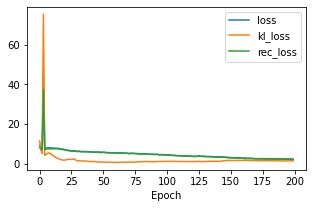

In [232]:
history.plot(figsize=(5, 3), xlabel='Epoch')

In [233]:
x_hat, x_025, x_975, u_hat, u_025, u_975 = dkf.predict(
    x_ten, u=u_ten, pred_steps=100, num_sample=500)

x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
u_hat = u_hat.detach().numpy()[0]
u_025 = u_025.detach().numpy()[0]
u_975 = u_975.detach().numpy()[0]

In [234]:
def plot_predictions(x, x_pred, x_025=None, x_975=None,
                     dims=None, val_steps=0, test_steps=0, wd=8,
                     title=None):

    assert x.ndim == 2
    if dims is None: dims = np.arange(x.shape[1])

    n_dims = len(dims)
    fig, ax = plt.subplots(n_dims, figsize=(wd, 2*n_dims))

    def plot_org(ax, xticks, x):
        ax.scatter(xticks, x, s=10, alpha=0.8, label='Data', c='#7F7F7F')
    def plot_pred(ax, xticks, x):
        ax.plot(xticks, x, c='#3399cc', label='Prediction')
    def plot_interval(ax, xticks, lower, upper):
        ax.fill_between(xticks, lower, upper, facecolor='#3399cc', alpha=0.2)

    xticks = np.arange(len(x))
    for d, axi in zip(dims, ax):

        plot_org(axi, xticks, x[:, d])
        plot_pred(axi, xticks, x_pred[:, d])
        if x_025 is not None and x_975 is not None:
            plot_interval(axi, xticks, x_025[:, d], x_975[:, d])

        ymin, ymax = axi.get_ylim()
        if val_steps > 0:
            axi.vlines(len(x) - val_steps - test_steps, ymin, ymax, ls=':', color='black')
        if test_steps > 0:
            axi.vlines(len(x) - test_steps, ymin, ymax, ls=':', color='black')

        axi.set_xlim(0, len(x))
        axi.set_ylabel('Value')
        axi.legend(loc='upper left', fancybox=False)
    
    if title is not None: ax[0].set_title(title)
    ax[-1].set_xlabel('Time')
    fig.tight_layout()

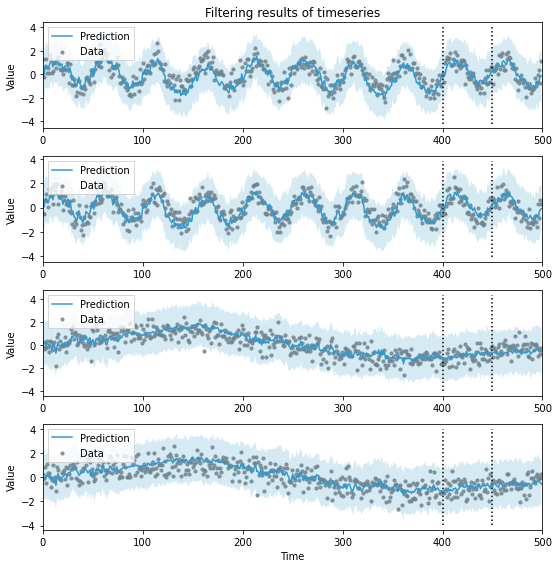

In [235]:
plot_predictions(data, x_hat, x_025, x_975,
                 val_steps=50, test_steps=50,
                 title='Filtering results of timeseries')

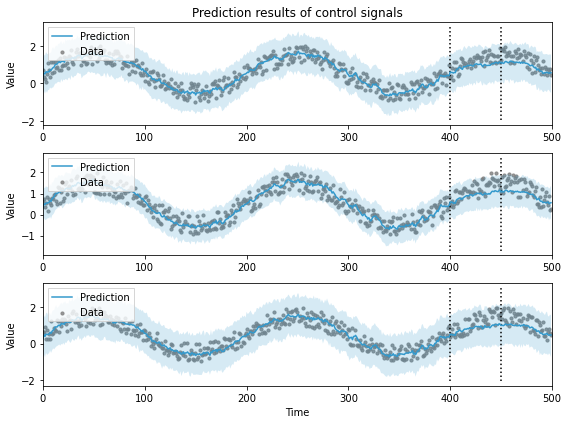

In [236]:
plot_predictions(signal, u_hat, u_025, u_975,
                 val_steps=50, test_steps=50,
                 title='Prediction results of control signals')